In [3]:
import sys
sys.path.append('../src')

from pathlib import Path
from tqdm import tqdm
import polars as pl
import re

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

sns.set_style('whitegrid')

In [9]:
base_path = Path("/projectnb/vkolagrp/bellitti/clinicalnotes-databasing-validated")

tabular = pl.read_parquet(base_path / "results/NBSE_tabulated.parquet").rename(
    {"neuropsychological_testing_recommended": "np_recommended"}
)

In [10]:
# Assume all indetermined encounter types are in person?
# tabular = tabular.with_columns(
#     pl.col('encounter_type').fill_null('in-person'),
# )

# Assume all indetermined encounter types before COVID are in person?
# tabular = tabular.with_columns(
#     pl.when(pl.col('completed') < pd.to_datetime('2020-01-01')).then(pl.lit('in-person')).otherwise('encounter_type').alias('encounter_type')
#     )


In [13]:
full_texts = pl.read_parquet(base_path / 'results/full_reports.parquet')

df = tabular.join(full_texts.select('VAC','nchars'), on='VAC',how='inner').sort('completed')

df.shape

(1858, 29)

In [14]:
df.null_count()

completed,age,sex,education,encounter_type,moca_total_score,mmse_total_score,aces_total_score,cerad_encoding_total,cerad_delayed_recall,cerad_corrected_recognition_total,trailsa_time_in_seconds,trailsa_errors,trailsb_time_in_seconds,trailsb_errors,letter_fluency_total,category_fluency_total,boston_naming_total_score,verbal_naming_total_score,medications,adl_impaired,iadl_impaired,diagnosis,clinical_syndrome,np_recommended,pet_recommended,filename,VAC,nchars
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
8,0,28,1,246,598,713,1742,2,3,3,25,105,268,418,1,2,526,1332,328,375,457,3,122,1131,1299,0,0,0


There were two VAC with multiple reports, we excluded them by hand

In [17]:
sections = [
 'VAC',
 'completed',
 'encounter_type',
 'age',
 'sex',
 'education',
 'moca_total_score',
 'mmse_total_score',
 'aces_total_score',
#  'clock_drawing_notes',
 'cerad_encoding_total',
 'trailsa_time_in_seconds',
 'trailsb_time_in_seconds',
 'letter_fluency_total',
 'category_fluency_total',
 'boston_naming_total_score',
 'verbal_naming_total_score',
 'gds_total_score',
 'gai_total_score',
 'lubben_total_score',
 'ucla_loneliness_total_score',
 'behavioral_observations',
 'history',
 'medications',
 'summary',
 'adl_impaired',
 'diagnosis',
 'specific_clinical_syndrome',
 'underlying_etiology',
 'np_recommended',
]

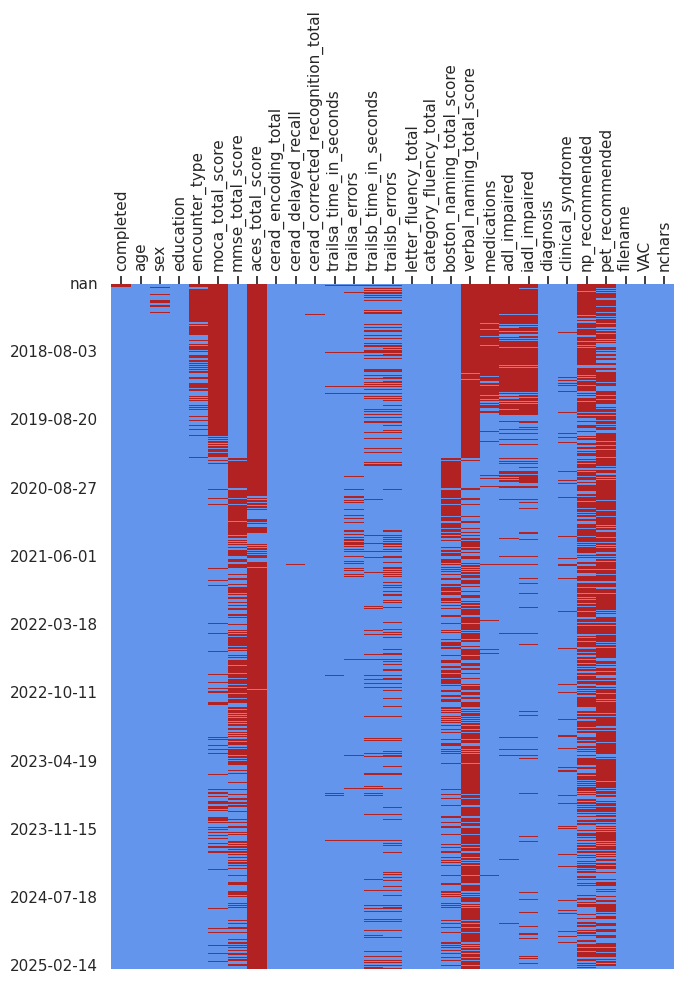

In [25]:
mat = df.with_columns(
    pl.all().is_null()
).to_pandas().astype(int)

y_labels = df["completed"].to_pandas().dt.strftime('%F')

color_true = 'cornflowerblue' 
color_false = 'firebrick'
cmap = sns.color_palette([
    color_true,
    color_false, 
    ])

fig, ax = plt.subplots(1,1,figsize=(7, 10))

g = sns.heatmap(
    mat,
    cmap=cmap,
    cbar=False,
    yticklabels=y_labels, 
    ax=ax,
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.xaxis.tick_top()

# Thin out y-axis ticks 
step = max(1, len(y_labels) // 10)  # show about 20 ticks
for i, label in enumerate(ax.get_yticklabels()):
    if i % step != 0:
        label.set_visible(False)

# ax.set_xlabel("Section")
# ax.xaxis.set_label_position("top")
# ax.set_ylabel("Date")   # if you want no y labels, use ax.set_yticks([])

# Show x-axis on top

fig.tight_layout()

In [12]:
# fig.savefig('../figures/figures_missing_map.png',bbox_inches='tight')

A few very old NBSE do not have a completion date

The VAC are assigned sequentially

Text(0, 0.5, 'VAC')

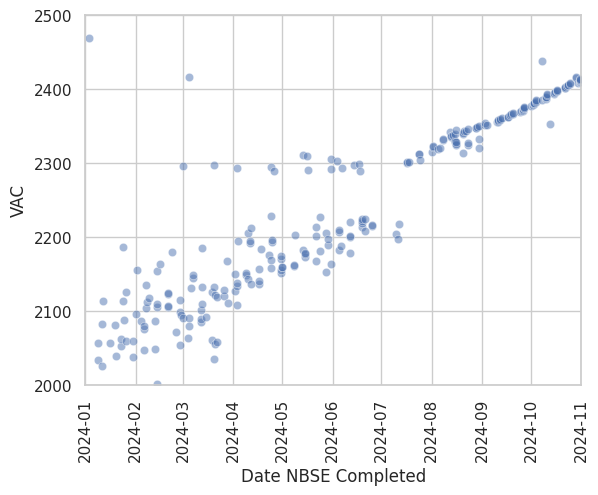

In [26]:
sns.scatterplot(
    df.to_pandas(),
    x='completed',
    y='VAC',
    alpha=0.5
    #native_scale=True
)

plt.ylim(2000,2500)
plt.xlim(
    pd.to_datetime('2024-01-01'),
    pd.to_datetime('2024-11-01'),
    )

plt.xticks(rotation=90)

plt.xlabel('Date NBSE Completed')
plt.ylabel('VAC')

# plt.savefig('../figures/vac_gap.svg',bbox_inches='tight')

Text(57.0, 0.5, 'Length of NBSE (characters)')

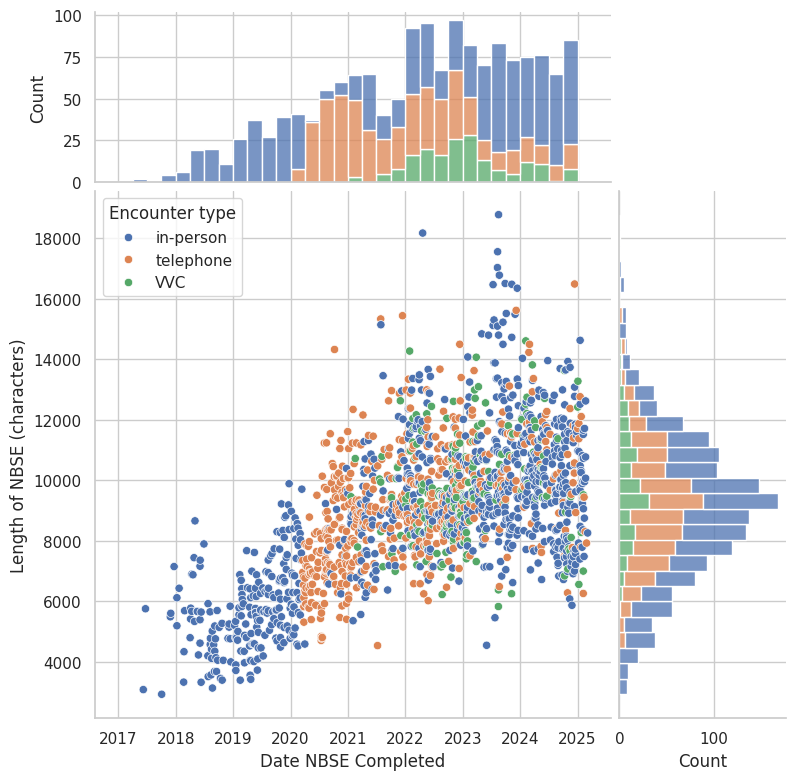

In [27]:
bins = pd.date_range(start="2017-01-01", end="2025-03-30", freq="3MS").values

_df = df.filter(pl.col("completed").is_null().not_()).to_pandas()

# Create the joint plot with marginal histograms
g = sns.JointGrid(
    data=_df,
    x="completed",
    y="nchars",
    hue="encounter_type",
    marginal_ticks=True,
    height=8,
    ratio=3,  # makes joint plot larger than marginal hist
    space=0.05,
    hue_order=["in-person", "telephone", "VVC"],
)

g.plot_joint(sns.scatterplot)

sns.histplot(
    _df,
    x="completed",
    hue="encounter_type",
    multiple="stack",
    bins=mpl.dates.date2num(bins),
    ax=g.ax_marg_x,
    legend=False,
    hue_order=["in-person", "telephone", "VVC"],
)

sns.histplot(
    _df,
    y="nchars",
    hue="encounter_type",
    multiple="stack",
    ax=g.ax_marg_y,
    legend=False,
    hue_order=["in-person", "telephone", "VVC"],
)

g.ax_joint.legend(title="Encounter type")

# Labels for main axes
g.ax_joint.set_xlabel("Date NBSE Completed")
g.ax_joint.set_ylabel("Length of NBSE (characters)")

# g.savefig("../figures/length_phone.svg", bbox_inches="tight")

In [28]:
encounter_fracs = df.select(
    'completed',
    'encounter_type'
).sort('completed').with_columns(
    pl.col('completed').dt.round(every='1q')
).drop_nulls()
# .sort('completed').group_by_dynamic("completed", every="1y", period="1y").agg(pl.col('encounter_type').count())#.value_counts(normalize=True).alias('vc')).explode('vc').unnest('vc')
#.agg(pl.col('encounter_type'))#.value_counts(normalize=True).alias('vc')).explode('vc').unnest('vc')

encounter_fracs

completed,encounter_type
date,str
2017-07-01,"""in-person"""
2017-07-01,"""in-person"""
2017-10-01,"""in-person"""
2018-01-01,"""in-person"""
2018-01-01,"""in-person"""
…,…
2025-04-01,"""in-person"""
2025-04-01,"""in-person"""
2025-04-01,"""in-person"""


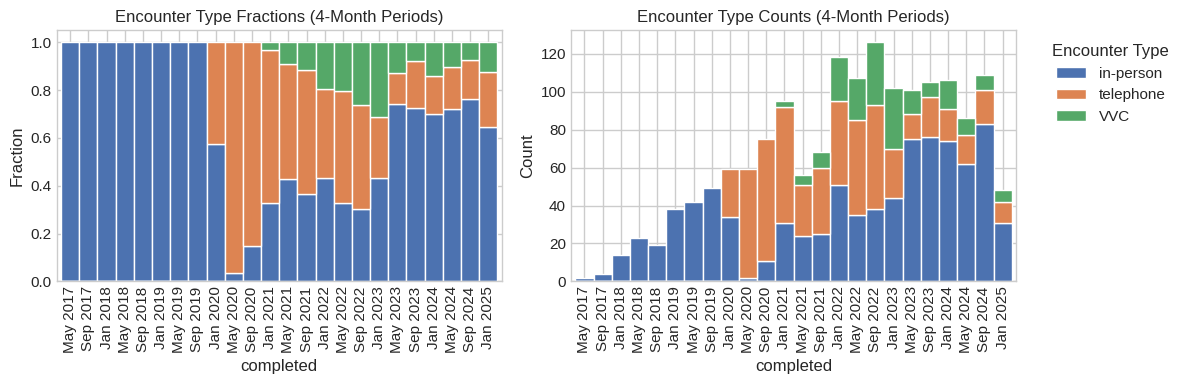

In [31]:
# Bin by quarter
plt.style.use( 'seaborn-v0_8-whitegrid')


_df = df.sort('completed').to_pandas()

# Count per 6-month period and encounter type
counts = (
    _df.groupby([pd.Grouper(key="completed", freq="4MS"), "encounter_type"])
       .size()
       .reset_index(name="count")
)

# Fractions
counts["fraction"] = counts.groupby("completed")["count"].transform(lambda x: x / x.sum())

# Pivot for stacked bar plotting
fractions = counts.pivot(index="completed", columns="encounter_type", values="fraction").fillna(0)
counts_pivot = counts.pivot(index="completed", columns="encounter_type", values="count").fillna(0)

# Reorder columns
order = ["in-person", "telephone", "VVC"]
fractions = fractions[order]
counts_pivot = counts_pivot[order]

# Two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

# Fractions plot
fractions.plot(kind="bar", stacked=True, ax=axes[0], width=1.0)
axes[0].set_ylabel("Fraction")
axes[0].set_title("Encounter Type Fractions (4-Month Periods)")
axes[0].set_xticklabels([d.strftime("%b %Y") for d in fractions.index], rotation=90, ha="center")
axes[0].legend_.remove()

# Counts plot
counts_pivot.plot(kind="bar", stacked=True, ax=axes[1], width=1.0)
axes[1].set_ylabel("Count")
axes[1].set_title("Encounter Type Counts (4-Month Periods)")
axes[1].set_xticklabels([d.strftime("%b %Y") for d in counts_pivot.index], rotation=90, ha="center")

# Legend outside
axes[1].legend(title="Encounter Type", bbox_to_anchor=(1.05, 1), loc="upper left")

fig.tight_layout()

In [17]:
# fig.savefig('../figures/encounter_fracs.svg')

In [18]:
df.filter(
    (pl.col('encounter_type') == 'VVC') &
    (pl.col('completed') < pd.to_datetime('2020-01-01'))
).select('completed','filename')

completed,filename
date,str


Neuropsych recommended?

/scratch/474313.1.cds/ipykernel_219478/3251764316.py:5: FutureWarning: 'y' is deprecated and will be removed in a future version, please use 'YE' instead.
  _df.groupby(pd.Grouper(key="completed", freq="y"))


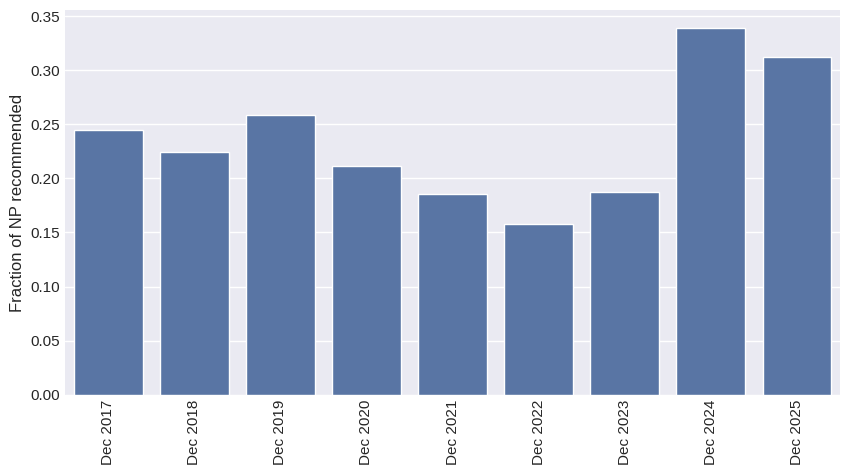

In [19]:
_df = df.select('completed',pl.col('np_recommended').fill_null(False)).filter(pl.col('completed').is_not_null()).to_pandas()

# Resample by month and count True values
fractions = (
    _df.groupby(pd.Grouper(key="completed", freq="y"))
    .np_recommended
    .mean()
    .reset_index(name="fraction")
)

# fractions["completed_str"] = fractions["completed"].dt.strftime("%b %Y")
fractions["completed_str"] = fractions["completed"].dt.strftime("%b %Y")

# Plot with Seaborn
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=fractions, x="completed_str", y="fraction", ax=ax, )

ax.set_ylabel("Fraction of NP recommended")
ax.set_xlabel("")
# ax.set_title("Number of NP Recommended Over Time")
ax.tick_params(axis='x', labelrotation=90)

# fig.savefig('../figures/npfrac_year.svg',bbox_inches='tight')

Text(0.5, 0, 'Fraction of NBSE Reports')

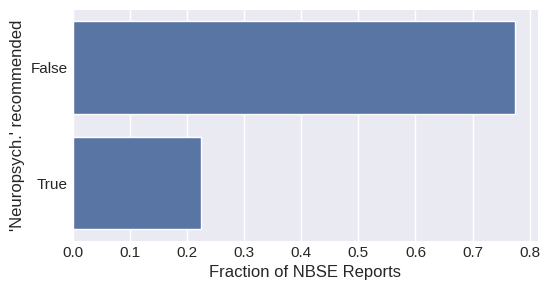

In [20]:
fig,ax = plt.subplots(1,1,figsize=(6,3))

sns.countplot(df.select(pl.col('np_recommended').fill_null(False)).to_pandas(),
    y='np_recommended',
    stat='proportion',
    ax=ax
)

ax.set_ylabel("'Neuropsych.' recommended")
ax.set_xlabel('Fraction of NBSE Reports')

# fig.savefig('../figures/neuropsych.svg',bbox_inches='tight')

There may be more than one ingredient in a drug. Should we concatenate everything into a single list? Should we keep track of the dosage?